In [1]:
# Librerías necesarias
import pandas as pd
import requests
import geopandas
from shapely.geometry import Point
import shapely.wkt
import rtree
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Bajar un archivo de google drive
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    tamaño_cache = 32768

    with open(destination, "wb") as f:
        for cache in response.iter_content(tamaño_cache):
            if cache: # filter out keep-alive new chunks
                f.write(cache)
                
# Bajamos el archivo con los geonames de Argentina de google drive
file_id = '13NQ9j2Ina8zKtnA9ygRb81RWM_pYAg1N'
download_file_from_google_drive(file_id, 'geonames_AR.txt')

In [3]:
# Cargamos el archivo en un dataframe

dtypes_dict = {
    0: int, # geonameid
    1: str,  # name
    2: str,  # asciiname
    3: str,  # alternatenames
    4: float, # latitude
    5: float, # longitude
    6: str, # feature class
    7: str, # feature code
    8: str, # country code
    9: str, # cc2
    10: str, # admin1 code
    11: str, # admin2 code
    12: str, # admin3 code
    13: str, # admin4 code
    14: int, # population
    15: float, # elevation
    16: int, # dem (digital elevation model)
    17: str, # timezone
    18: str # modification date yyyy-MM-dd
}
col_names_dict = [
    'geoname_id', # geonameid
    'name',  # name
    'asciiname',  # asciiname
    'alternatenames',  # alternatenames
    'lat', # latitude
    'lon', # longitude
    6, # feature class
    7, # feature code
    8, # country code
    9, # cc2
    10, # admin1 code
    11, # admin2 code
    12, # admin3 code
    13, # admin4 code
    'population', # population
    'elevation', # elevation
    'dem', # dem (digital elevation model)
    'timezone', # timezone
    'last_modif' # modification date yyyy-MM-dd
]

geonames = pd.read_csv("geonames_AR.txt", sep="\t", header = None, dtype=dtypes_dict, decimal=".", names=col_names_dict)

In [4]:
# A partir de un geonames_id retorna los datos de Latitud y Longitus dentro de un Pandas.DataFrame.
def get_lat_lon(geonames_id):
  return geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']

In [5]:
# Pruebas
print(geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']['lat'].iloc[0])
print(geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']['lon'].iloc[0])

-34.66583
-58.728280000000005


In [6]:
# Pruebas
"{} {}".format(str(geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']['lat'].iloc[0]), str(geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']['lon'].iloc[0]))

'-34.66583 -58.728280000000005'

In [7]:
# A partir de un geonames_id retorna los datos de Latitud y Longitus correspondiente, dentro de un Pandas.DataFrame.
def get_lat_long(geonames_id):
  return "{} {}".format(str(geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']['lat'].iloc[0]), str(geonames.loc[geonames['geoname_id'] == 3430696,'lat':'lon']['lon'].iloc[0]))

In [8]:
# Prueba 1
get_lat_long(3430696)

'-34.66583 -58.728280000000005'

In [9]:
# Prueba 2
get_lat_lon(3430696)

,lat,lon
3486,-34.66583,-58.72828


In [10]:
# Usamos geopandas para obtener el mapa de Argentina
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

geopandas.geodataframe.GeoDataFrame

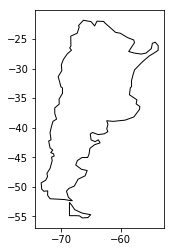

In [11]:
argentina = world[world.name == 'Argentina']
argentina.plot(color='white', edgecolor='black')
type(argentina)

In [12]:
# Pasaje de latitud-longitud a puntos de coordenadas
def from_x_y(df, x, y):
    from shapely.geometry import Point
    gdf = geopandas.GeoDataFrame(df.drop([x, y], axis=1),
                                crs={'init': 'epsg:4326'},
                                geometry=[Point(xy) for xy in zip(df[x], df[y])])
    return gdf

## Detectar propiedades Geolocalizadas fuera de Argentina

**Hipótesis:** existen registros en el dataset provisto cuya geolocalización es incorrecta.


### Importamos el dataset provisto de propiedades

Lectura y carga del archivo de datos en Dataframe de Pandas.

In [13]:
df_props = pd.read_csv("properatti.csv"
           , encoding = 'utf-8', decimal=".")

Para este análisis necesito remover los valores nulos para la geolocalización, para poder analizar los que efectivamente tienen valores.

In [14]:
df_props = df_props.dropna(subset=['lat-lon'])

In [15]:
props_gdf = from_x_y(df_props, "lon", "lat")
type(props_gdf)

geopandas.geodataframe.GeoDataFrame

#### Gráfico de intersección

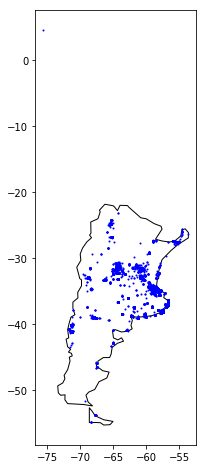

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_aspect('equal')
argentina.plot(ax=ax, color='white', edgecolor='black')
props_gdf.plot(ax=ax, marker='o', color='blue', markersize=1)
plt.show();

Listar los que están marcados fuera de Argentina

<class 'list'>
En Argentina: 61286
Fuera de Argentina: 8384


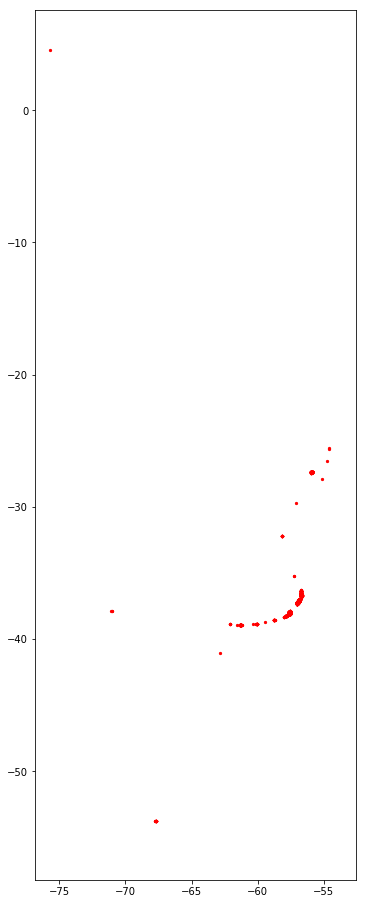

In [17]:
# Calculando los puntos dentro del polígono 

pointsinside = geopandas.sjoin(props_gdf,argentina,how="inner")

index_outside = [~props_gdf.index.isin(pointsinside.index)]
print(type(index_outside))
pointsoutside = props_gdf[~props_gdf.index.isin(pointsinside.index)]


# Grafico 
fig, ax = plt.subplots(figsize=(18, 16))
ax.set_aspect('equal')
argentina.plot(color = 'white',ax=ax)
#pointsinside.plot(ax=ax,marker='o', color='green', markersize=5)

pointsoutside.plot(ax=ax,marker='o', color='red', markersize=5)

#print('Total points:' ,len(points))
print('En Argentina:' ,len(pointsinside))
print('Fuera de Argentina:' ,len(pointsoutside))

**Observación:** se observa claramente un punto fuera de la región, en Latitud Norte, quizás se debe a un error en la carga del signo.

In [20]:
display(df_props.loc[df_props['lat'] > 0])

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
9761,9761,sell,house,Córdoba,|Argentina|Córdoba|,Argentina,Córdoba,3860255.0,"4.5458426,-75.67893099",4.545843,...,NaN,NaN,NaN,2.0,3.0,NaN,http://www.properati.com.ar/165i3_venta_casa_c...,Casa en Venta de 2 dorm. en Armenia,SE VENDE CASA EN EL BARRIO EL LIMONAR,https://thumbs4.properati.com/2/2huBKPZv0RyWda...


In [21]:
display(geonames.loc[geonames['name'] == "Córdoba"])
display(geonames.loc[geonames['geoname_id'] == 3860255.0])

,geoname_id,name,asciiname,alternatenames,lat,lon,6,7,8,9,10,11,12,13,population,elevation,dem,timezone,last_modif
37525,3860259,Córdoba,Cordoba,"COR,Ciudad de Cordoba,Ciudad de Córdoba,Cordob...",-31.4135,-64.18105,P,PPLA,AR,NaN,05,14014,NaN,NaN,1428214,NaN,395,America/Argentina/Cordoba,2016-07-29


,geoname_id,name,asciiname,alternatenames,lat,lon,6,7,8,9,10,11,12,13,population,elevation,dem,timezone,last_modif
37521,3860255,Córdoba Province,Cordoba Province,"CD,Cordoba,Cordoba Province,Córdoba,Provincia ...",-32.0,-64.0,A,ADM1,AR,NaN,05,NaN,NaN,NaN,3066801,NaN,373,America/Argentina/Cordoba,2016-10-21
